In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.cross_validation import train_test_split
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sqlalchemy as sa

from IPython.display import clear_output

import pickle

# Optimize one-class SVM outlier model

    - Use the retired, non-UFC fighters to train the outlier model. The retired and active UFC fighters can serve in the validation and test sets.
    - Get the distributions of win % in the validation set. Optimize for a threshold to reclassify outliers with low win %.
    - Optimize one class parameters gamma and nu for the rbf kernel.
    - Explore predictions.

In [2]:
# Initialze connection to MySQL
engine = sa.create_engine('mysql+pymysql://root:@localhost:3306/fight_db', echo=True)
con = engine.connect()

clear_output()

In [3]:
to_array = lambda x: x.values.astype(float)

In [4]:
# Build function to prepare dataframe for splitting
def get_df(active,ufc_has):
    # active and ufc_has are boolean options for output
    fighters = pd.read_sql('SELECT * FROM `features01`',con=engine)
    fighters.drop(['index'],inplace=True,axis=1)
    fighters = fighters.drop_duplicates()
   
    # Clean up for models
    fighters.drop(['name'],inplace=True,axis=1)
    fighters.drop(['age'],inplace=True,axis=1)
    fighters.drop(['locality'],inplace=True,axis=1)
    fighters.drop(['ufc.current'],inplace=True,axis=1)
    fighters.drop(['ufc.champ'],inplace=True,axis=1)
    fighters.drop(['win.pct.all'],inplace=True,axis=1)
 
    if active == 1:
        out = DataFrame(fighters[fighters['active']==1])
    else:
        out = DataFrame(fighters[fighters['active']==0])
    
    if ufc_has == 1:
        out = DataFrame(out[out['ufc.has']==1])
    else:
        out = DataFrame(out[out['ufc.has']==0])

    clear_output()
    return out

In [5]:
# Train with retired non-ufc (minus a split off)
x_train = get_df(0,0)

# postive cases for validation/testing are active and inactive ufc
y_val_test01 = get_df(0,1)
y_val_test02 = get_df(1,1)
y_val_test = pd.concat([y_val_test01,y_val_test02])

# Predict/analyze the active, non-ufc fighters
y_predict = get_df(1,0).reset_index(inplace=False)

In [6]:
# Split up and orgainze the sets. 
print(len(x_train))
print(len(y_val_test))

split_factor = len(y_val_test)/len(x_train)
split_factor

8509
1371


0.1611235162768833

In [7]:
# split off of training set
x_train_set,x_val_test = train_test_split(x_train, test_size=split_factor, random_state=42)

print(len(x_train_set))
print(len(x_val_test))
x_train_set.reset_index(inplace=True)

7138
1371


In [8]:
# make val and test sets. Catenate for the model. 
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size=0.25,random_state=56)

print(len(x_val))
print(len(x_test))
print(len(y_val))
print(len(y_test))

val = pd.concat([x_val,y_val]).reset_index(inplace=False)
test = pd.concat([x_test,y_test]).reset_index(inplace=False)

1028
343
1028
343


In [9]:
def OCSVM(nu,kernel,gamma,training):
    """Fit a one-class SVM model using a DataFrame. see help(sklearn.svm.OneClassSVM)
    for more information. 
    
    Args:
    nu (float): An upper bound on the fraction of training errors and a 
    lower bound of the fraction of support vectors.
    
    kernel (string): SVM kernel function. Options include 'rbf','poly'
    ,'linear',or 'sigmoid'.
    
    gamma (float): Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    
    training (DataFrame): The full training set that includes features, index,
    and labels
    

    Returns:
    mod (obj): the fit one-class SVM model object
    """
    mod = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
    arr = to_array(training.drop(['ufc.has','active','index'],inplace=False,axis=1))
    mod.fit(arr)
    
    return mod

In [10]:
def predict(model,test,use_cut=True,cutoff=0.69):
    """Predict using the one-class SVM model. See help(sklearn.svm.OneClassSVM)
    for more information. 
    
    Args:
    model (obj): The one-class SVM model object fit with OCSVM()
    
    Test (DataFrame): Observations to be predicted upon. Includes features
    index,and labels. 
    
    use_cut (Bool): Whether or not to use win % cutoff for reclassification
    of outliers back to normal.
    
    cutoff (float): threshold for reclassification of outliers back to normal.
    

    Returns:
    precision, accruacy (float): Precision and accuracy of classification
    
    tp,fp,fn,tn (float): true positives, false positives, false negatives, 
    true negatives
    """
    test_temp = DataFrame(test)
    
    if 'pred' in test_temp.columns:
        test_temp.drop(['pred'],inplace=True,axis=1)

    arr = to_array(test_temp.drop(['ufc.has','active','index'],inplace=False,axis=1))
    pred = model.predict(arr)

    # Shift outcomes from -1,1 to 0,1
    pred[pred == 1] = 0
    pred[pred == -1] = 1

    test_temp['pred'] = Series(pred)

    if use_cut == True:
        test_temp.loc[(test_temp['pred']==1) & (test_temp['win.pct.pre']<cutoff),'pred'] = 0

    tp = test_temp.loc[(test_temp['pred']==1) & (test_temp['ufc.has'] == 1),'pred'].count()
    fp = test_temp.loc[(test_temp['pred']==1) & (test_temp['ufc.has'] == 0),'pred'].count()
    fn = test_temp.loc[(test_temp['pred']==0) & (test_temp['ufc.has'] == 1),'pred'].count()
    tn = test_temp.loc[(test_temp['pred']==0) & (test_temp['ufc.has'] == 0),'pred'].count()

    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    
    
    return precision, accuracy, test_temp['pred'].values, tp, fp, fn, tn

In [11]:
kernel = "rbf"

nus = np.linspace(0.01,0.1,10)
gammas = np.linspace(0.05,0.5,10)

In [12]:
precision_rbf=[]
accuracy_rbf=[]

for nu in nus:
     for gamma in gammas:
        model = OCSVM(nu,kernel,gamma,x_train_set)
        out = predict(model,val,True,0.715)
        precision_rbf.append(out[0])
        accuracy_rbf.append(out[1])
        #print("nu = {}, gamma = {}".format(nu,gamma))


0.79028132992327371

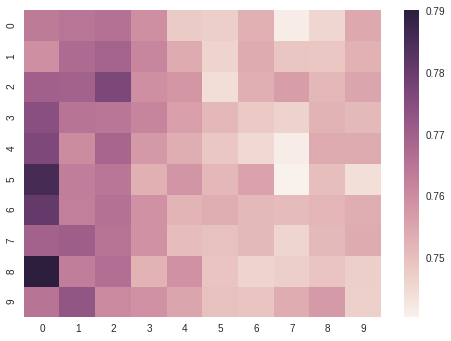

In [13]:
# after two searches, nu=0.05 and gamma = 0.05 is the best for rbf
# plt.plot(precision_rbf)
sns.heatmap(np.array(precision_rbf).reshape(10,10))
np.max(precision_rbf)


In [14]:
print(precision_rbf[80])
print(nus[8],gammas[0])

0.790281329923
0.09 0.05


In [15]:
# Summary of best coditions with and without threshold
model = OCSVM(0.09,"rbf",0.05,x_train_set)
out = predict(model,val,False)
print("Precision and accuracy without threshold: {:.2f}, {:.2f}".format(out[0],out[1]))

out_thresh = predict(model,val,True,0.715)
print("Precision and accuracy with threshold: {:.2f}, {:.2f}".format(out_thresh[0],out_thresh[1]))


Precision and accuracy without threshold: 0.62, 0.58
Precision and accuracy with threshold: 0.79, 0.61


In [16]:
# Comparable results for the test set suggests no overfitting. 
out_test= predict(model,test,True,0.715)
print("Precision and accuracy for the test set: {:.2f}, {:.2f}".format(out_test[0],out_test[1]))

Precision and accuracy for the test set: 0.76, 0.61


In [17]:
# Pickle the model for use in the web-app
pickle.dump(model,open('outlier03.pkl',"wb"),protocol=2)

#Predict on the active, non-UFC fighters

In [18]:
out_pred = predict(model,y_predict,True,0.715)
y_predict['pred'] = Series(out_pred[2])

In [19]:
# Need to get a full dataframe for insights
fighters = pd.read_sql('SELECT * FROM `features01`',con=engine)
fighters.drop(['index'],inplace=True,axis=1)
fighters = fighters.drop_duplicates()

fighters = DataFrame(fighters[fighters['active']==1])
fighters = DataFrame(fighters[fighters['ufc.has']==0]).reset_index(inplace=False)

clear_output()

In [20]:
fighters['pred'] = y_predict['pred']

In [21]:
print("There are {} predicted UFC fighters out of {} active non-UFC fighters"
      .format(len(fighters[fighters['pred']==1]),len(fighters)))

There are 699 predicted UFC fighters out of 7843 active non-UFC fighters


In [22]:
predict_ufc = fighters[fighters['pred']==1]

In [23]:
# Predicted UFC fighters in California
in_ca = predict_ufc[predict_ufc['locality'].str.contains(', Ca')]
print("There are {} fighters with UFC potential in CA.".format(len(in_ca)))

There are 57 fighters with UFC potential in CA.


In [24]:
# Some of the top prospects according to win pct and number of fights
(predict_ufc[['name','locality','win.pct.all','n.fights.pre']]
 .sort(columns=['win.pct.all','n.fights.pre'],ascending=False).loc[:100])

,name,locality,win.pct.all,n.fights.pre
7569,Justin Gaethje,"Safford, Arizona",1,22
6560,Kairat Akhmetov,"Taldykorgan, Almaty",1,21
3736,Ben Reiter,"Coram, New York",1,17
5128,Vagab Vagabov,"Makhachkala, Republic of Dagestan",1,16
5111,Vitaly Minakov,"Bryansk, Bryansk",1,15
2071,Shane Burgos,"Woodbury, New York",1,13
100,Dean Garnett,"Liverpool, Merseyside",1,10
